Coût total de la solution : 1673.7105598381343
Temps total de service : 1673.7105598381343
Clients non desservis :

Camion 1:
Heure de retour au dépôt : 29.0 minutes
Coût du trajet : 29.0
Chemin du camion : [0, np.int64(20), np.int64(21), np.int64(47)]
Poids de la marchandise : 40 unités

Camion 2:
Heure de retour au dépôt : 76.19328143791638 minutes
Coût du trajet : 76.19328143791638
Chemin du camion : [0, np.int64(22), np.int64(49)]
Poids de la marchandise : 30 unités

Camion 3:
Heure de retour au dépôt : 136.60920976594863 minutes
Coût du trajet : 136.60920976594863
Chemin du camion : [0, np.int64(67), np.int64(65), np.int64(63), np.int64(62), np.int64(74), np.int64(72), np.int64(61), np.int64(64), np.int64(68), np.int64(69)]
Poids de la marchandise : 190 unités

Camion 4:
Heure de retour au dépôt : 185.14368099010653 minutes
Coût du trajet : 185.14368099010653
Chemin du camion : [0, np.int64(23), np.int64(75)]
Poids de la marchandise : 30 unités

Camion 5:
Heure de retour au dépôt 

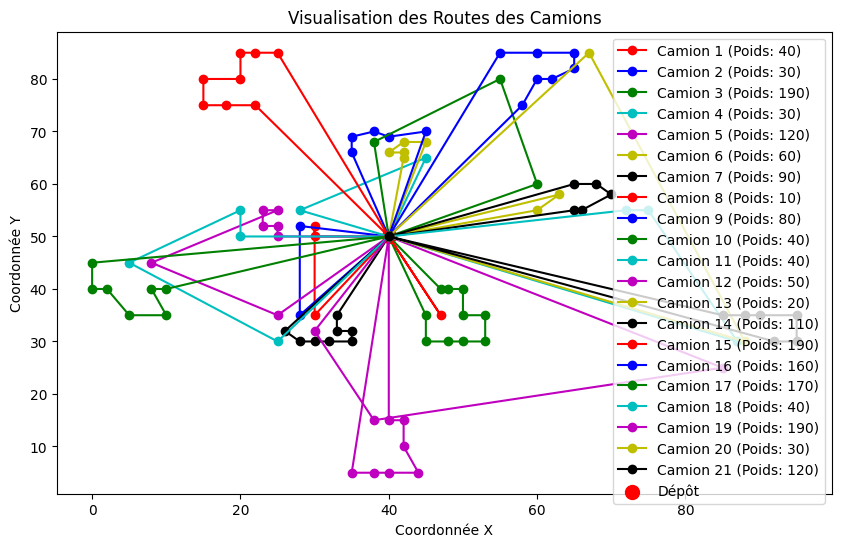

In [35]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt

# Step 1: Parse Data
def parse_data(file_path):
    try:
        with open(file_path, 'r') as f:
            lines = f.readlines()

        vehicle_index = next(i for i, line in enumerate(lines) if "VEHICLE" in line)
        max_vehicles = int(lines[vehicle_index + 2].split()[0])
        vehicle_capacity = int(lines[vehicle_index + 2].split()[1])

        customer_index = next(i for i, line in enumerate(lines) if "CUSTOMER" in line)
        depot_coords = None
        ready_time = None
        due_date = None
        customer_data = []

        for line in lines[customer_index + 2:]:
            data = line.strip().split()
            if len(data) == 7:
                customer_id = int(data[0])
                xcoord = float(data[1])
                ycoord = float(data[2])
                demand = int(data[3])
                ready_time_cust = int(data[4])
                due_date_cust = int(data[5])
                service_time = int(data[6])
                
                if customer_id == 0:
                    depot_coords = {'x': xcoord, 'y': ycoord}
                    ready_time = ready_time_cust
                    due_date = due_date_cust
                else:
                    customer_data.append({
                        'id': customer_id,
                        'x': xcoord,
                        'y': ycoord,
                        'demand': demand,
                        'ready_time': ready_time_cust,
                        'due_date': due_date_cust,
                        'service_time': service_time
                    })

        if depot_coords is None:
            raise ValueError("Coordonnées du dépôt manquantes ou incorrectes dans le fichier.")
        return depot_coords, ready_time, due_date, max_vehicles, vehicle_capacity, customer_data
    except Exception as e:
        print(f"An error occurred while parsing data: {e}")
        return None


# ACO Class
class AntColonyOptimization:
    def __init__(self, num_vehicles, vehicle_capacity, customer_data, depot_coords, depot_ready_time, depot_due_date):
        self.num_vehicles = num_vehicles
        self.vehicle_capacity = vehicle_capacity
        self.customer_data = customer_data
        self.depot_coords = depot_coords
        self.depot_ready_time = depot_ready_time
        self.depot_due_date = depot_due_date
        self.distance_matrix = self.calculate_distance_matrix()
        self.pheromone = np.ones_like(self.distance_matrix)
        self.alpha = 1.0
        self.beta = 2.0
        self.best_solution = None
        self.best_cost = float('inf')
        self.unserved_customers = []  # Liste des clients non desservis

    def calculate_distance(self, p1, p2):
        """Calcul de la distance Euclidienne entre deux points"""
        return np.sqrt((p1['x'] - p2['x'])**2 + (p1['y'] - p2['y'])**2)

    def calculate_distance_matrix(self):
        """Générer une matrice des distances entre chaque client et le dépôt"""
        num_customers = len(self.customer_data)
        matrix = np.zeros((num_customers + 1, num_customers + 1))
        for i in range(num_customers + 1):
            for j in range(i + 1, num_customers + 1):
                if i == 0:
                    dist = self.calculate_distance(self.depot_coords, self.customer_data[j-1])
                elif j == 0:
                    dist = self.calculate_distance(self.depot_coords, self.customer_data[i-1])
                else:
                    dist = self.calculate_distance(self.customer_data[i-1], self.customer_data[j-1])
                matrix[i, j] = matrix[j, i] = dist
        return matrix

    def choose_next_customer(self, visited, current_customer, truck_load, current_time):
        """Choisir le prochain client à visiter"""
        pheromone = self.pheromone[current_customer]
        pheromone[visited] = 0
        distance = self.distance_matrix[current_customer] + 1e-6
        probability = pheromone ** self.alpha * (1.0 / distance) ** self.beta

        if np.sum(probability) == 0:
            probability = np.ones_like(probability)
        probability /= np.sum(probability)

        for next_customer in np.argsort(-probability):  # Try customers in probability order
            if next_customer not in visited and next_customer > 0:
                customer = self.customer_data[next_customer - 1]
                if (truck_load + customer['demand'] <= self.vehicle_capacity and
                        current_time + self.distance_matrix[current_customer, next_customer] <= customer['due_date']):
                    return next_customer
        return 0  # Return to depot

    def simulate_ant(self):
        """Simuler le comportement d'une fourmi (camion)"""
        routes = []
        visited = [0]
        total_distance = 0
        total_service_time = 0
        current_time = self.depot_ready_time
        unserved_customers = []  # Liste des clients non desservis pour cette simulation

        for _ in range(self.num_vehicles):
            route = []
            truck_load = 0
            current_customer = 0
            route_time = current_time
            truck_path = [0]  # Path of the truck, starting from the depot

            while True:
                next_customer = self.choose_next_customer(visited, current_customer, truck_load, route_time)
                if next_customer == 0:
                    break

                customer = self.customer_data[next_customer - 1]
                travel_time = self.distance_matrix[current_customer, next_customer]
                arrival_time = route_time + travel_time

                if arrival_time < customer['ready_time']:
                    arrival_time = customer['ready_time']  # Wait if arriving early
                if arrival_time > customer['due_date']:
                    unserved_customers.append(customer)  # Marquer le client comme non desservi
                    visited.append(next_customer)  # Ajouter le client comme "visité" pour éviter de le revisiter
                    continue  # Passer au client suivant

                route_time = arrival_time + customer['service_time']
                truck_load += customer['demand']
                visited.append(next_customer)
                route.append(next_customer)
                truck_path.append(next_customer)  # Ajouter le client au chemin du camion
                total_distance += travel_time
                total_service_time += customer['service_time']
                current_customer = next_customer

            if route:
                routes.append((route, truck_load, total_distance, total_service_time, truck_path))
                total_distance += self.distance_matrix[current_customer, 0]  # Return to depot
                route_time += self.distance_matrix[current_customer, 0]  # Update route time

        # Enregistrer les clients non desservis pour cette simulation
        for customer in self.customer_data:
            if customer['id'] not in visited and customer not in unserved_customers:
                unserved_customers.append(customer)

        self.unserved_customers = unserved_customers  # Met à jour la liste globale
        return routes, total_distance, total_service_time

    def run(self, iterations=100):
        """Lancer l'algorithme ACO"""
        for _ in range(iterations):
            solution, total_cost, total_service_time = self.simulate_ant()
            if total_cost < self.best_cost:
                self.best_cost = total_cost
                self.best_solution = solution
        return self.best_solution, self.best_cost, self.unserved_customers


# Plotting routes
def plot_routes(depot_coords, routes, customer_data):
    plt.figure(figsize=(10, 6))
    colors = ['r', 'b', 'g', 'c', 'm', 'y', 'k']  # Predefined colors for up to 7 trucks
    for i, (route, truck_load, _, _, _) in enumerate(routes):
        color = colors[i % len(colors)]
        x = [depot_coords['x']] + [customer_data[customer-1]['x'] for customer in route] + [depot_coords['x']]
        y = [depot_coords['y']] + [customer_data[customer-1]['y'] for customer in route] + [depot_coords['y']]
        plt.plot(x, y, marker='o', label=f"Camion {i+1} (Poids: {truck_load})", color=color)
    plt.scatter(depot_coords['x'], depot_coords['y'], color='red', s=100, label="Dépôt")
    plt.xlabel("Coordonnée X")
    plt.ylabel("Coordonnée Y")
    plt.title("Visualisation des Routes des Camions")
    plt.legend()
    plt.show()

# Main Function
def main():
    file_path = '../dataset/c101.txt'  # Remplacez ceci par le chemin de votre fichier de données
    data = parse_data(file_path)
    if data:
        depot_coords, depot_ready_time, depot_due_date, max_vehicles, vehicle_capacity, customer_data = data
        aco = AntColonyOptimization(max_vehicles, vehicle_capacity, customer_data, depot_coords, depot_ready_time, depot_due_date)
        solution, total_cost, unserved_customers = aco.run()

        print(f"Coût total de la solution : {total_cost}")
        print(f"Temps total de service : {total_cost}")
        print("Clients non desservis :")
        for customer in unserved_customers:
            print(f"Client {customer['id']}")

        # Affichage détaillé des informations par camion
        for i, (route, truck_load, total_distance, total_service_time, truck_path) in enumerate(solution):
            print(f"\nCamion {i+1}:")
            print(f"Heure de retour au dépôt : {total_distance} minutes")
            print(f"Coût du trajet : {total_distance}")
            print(f"Chemin du camion : {truck_path}")
            print(f"Poids de la marchandise : {truck_load} unités")

        plot_routes(depot_coords, solution, customer_data)


if __name__ == "__main__":
    main()
